In [2]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
from orig_anchor import anchor_text
import pickle
from myUtils import *
from transformer.utils import *
from dataset.dataset_loader import *
import datetime

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [3]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
review_parser, label_parser, ds_train, ds_val = spam_dataset()

747
4825
Number of tokens in training samples: 2690
Number of tokens in training labels: 2


In [4]:
model = load_model('gru' , 'transformer/spam/gru.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 5e-05, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(2690, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [5]:
# 1 = pad 2=sos 3 = eos
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [6]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>100):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)

    return torch.argmax(output, dim=1).cpu().numpy()

# Anchor Part

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False)

In [11]:
train, train_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]
test, test_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]

In [26]:
anchor_examples = [example for example in train if len(example) < 100 and len(example)>20]

In [27]:
len(anchor_examples)

204

In [28]:
from collections import Counter, defaultdict
from nltk.corpus import stopwords
def get_ignored(anchor_sentences):
    sentences = [[x.text for x in nlp(sentence)] for sentence in anchor_sentences]
    min_occurence = 1
    c = Counter()
    stop_words = list(".,- \'\"\s[]?():!;")
    stop_words.extend(["--", "'s", 'sos', 'eos'])
    stop_words.extend(stopwords.words('english'))
    """
    for sentence in sentences:
        c.update(sentence)
    sums = 0
    for ignore_s in stop_words:
        sums+=c[ignore_s]
        del c[ignore_s]
    print(sums)
    ignored_anchors = stop_words
    for key in c.keys():
        if c[key]<=min_occurence:
            ignored_anchors.append(key)
    print(len(c.keys()))
    return ignored_anchors
    """
    return stop_words

In [75]:
ignored = get_ignored(anchor_examples)

In [29]:
##### notice!!!!!
ignored = []

In [23]:
pickle.dump( test, open( "spam/transformer_test.pickle", "wb" ))
pickle.dump( test_labels, open( "spam/transformer_test_labels.pickle", "wb" ))
pickle.dump( anchor_examples, open( "spam/transformer_anchor_examples.pickle", "wb" ))

In [24]:
print(datetime.datetime.now())

2022-03-17 22:04:26.540776


In [ ]:
my_utils = TextUtils(anchor_examples, test, explainer, predict_sentences, ignored,"spam/transformer_exps.pickle")
explanations = my_utils.compute_explanations(list(range(len(anchor_examples))))

In [ ]:
print(datetime.datetime.now())

In [ ]:
pickle.dump( explanations, open( "spam/transformer_exps_list.pickle", "wb" ))

# Loading Results

In [9]:
test = np.array(pickle.load( open( "spam/transformer_test.pickle", "rb" )))
test_labels = np.array(pickle.load( open( "spam/transformer_test_labels.pickle", "rb" )))

explanations  = pickle.load(open( "spam/transformer_exps_list.pickle", "rb" ))
anchor_examples = pickle.load( open( "spam/transformer_anchor_examples.pickle", "rb" ))

In [10]:
len(anchor_examples)

628

In [12]:
len(explanations)

10952

In [16]:
test_predictions = np.array([predict_sentences([text])[0] for text in test])

In [17]:
explanations = [ExtendedExplanation(exp, anchor_examples, test, test_labels, test_predictions ,predict_sentences, explainer) for exp in explanations if len(exp.fit_examples) > 0]
pickle.dump( explanations, open( "spam/extended_exps.pickle", "wb" ))

In [18]:
len(explanations)

10952

In [10]:
explanations = pickle.load(open( "spam/extended_exps.pickle", "rb" ))

In [26]:
from collections import defaultdict
import pandas as pd
from nltk.corpus import stopwords

ignore = list(" .,- \'\"\s[]?():!;")
ignore.extend(["--", "'s", 'sos', 'eos'])
ignore.extend(stopwords.words('english'))
def aggregate_anchors(explanations, normalize = False):
    anchor_aggregator = defaultdict(list)
    for exp in explanations:
        name = exp.names[0]
        anchor_aggregator[name].append(exp)
        
    new_explanations = []
    label_factor = {0: 1 , 1: -1}
    num_both=0
    num_changed = 0
    num_deleted =0
    df_list = []
    for _, anchors in anchor_aggregator.items():
        # cut if below threshold
        prev_len = len(anchors)
        anchors = [anchor for anchor in anchors if anchor.precision >=0.95]
        if len(anchors)==0:
            num_deleted+=1
            continue
        after_len = len(anchors)

        if prev_len!=after_len:
            num_changed +=1
        labels = [predict_sentences([str(anchor_examples[anchor.index])])[0] for anchor in anchors]
        num_neg = sum(labels)
        num_pos = len(labels)-num_neg
        is_both = len(set(labels))>1
        if is_both:
            num_both+=1
        exp = anchors[0]
        exp.precision = sum([label_factor[label]*anchor.precision for anchor, label in zip(anchors, labels)])
        if normalize:
            exp.precision = exp.precision/prev_len
        new_explanations.append(exp)
        df_list.append([exp.names[0], exp.precision ,is_both,len(labels), prev_len, num_pos/len(labels), num_neg/len(labels)])
    
    df_list.sort(key=lambda exp: -abs(exp[1]))
    df = pd.DataFrame(data = df_list, columns = ['name', 'score', 'both labels', 'num anchors', 'num before','pos%', 'neg%']).set_index('name')
    if normalize:
        df.to_csv('spam/normalized_anchors.csv')
        df[~df.index.isin(ignore)].to_csv('spam/normalized_clean_anchors.csv')
        df[df['both labels'] == True].to_csv('spam/normalized_multiple.csv')
    else:
        df.to_csv('spam/anchors.csv') 
        df[~df.index.isin(ignore)].to_csv('spam/clean_anchors.csv')
        df[df['both labels'] == True].to_csv('spam/multiple.csv')

    print(f'both : {num_both}')
    print(f'changed : {num_changed}')
    print(f'deleted : {num_deleted}')
    return new_explanations

In [27]:
explanations = aggregate_anchors(explanations, normalize = True)

both : 35
changed : 409
deleted : 1281


In [65]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10] 
explanations.sort(key=lambda exp: exp.test_precision)

In [66]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>=4]
best = filtered[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = counter_test_labels[exp.fit_examples]
    
    print('Anchor test REAL precision: %.2f' % exp.real_precision)
   

------------------------
Prediction: negative
Anchor: mild
Precision: -1.00
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
Prediction: negative
Anchor: missed
Precision: -1.98
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
Prediction: negative
Anchor: pointless
Precision: -4.00
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.73
------------------------
Prediction: negative
Anchor: date
Precision: -2.64
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.02
Anchor test REAL precision: 0.58
------------------------
Prediction: negative
Anchor: material
Precision: -5.54
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.02
Anchor test REAL precision: 0.47
------------------------
Prediction: negative
Anchor: stupid
Precision: -4.97
Coverage: 0.00
A

In [46]:
exps = explanations[len(explanations)//2:]
exps = [exp for exp in exps if len(exp.fit_examples)>10]
#trained model has the opposite label
real_precisions = [exp.real_precision for exp in exps]
test_precisions = [exp.test_precision for exp in exps]

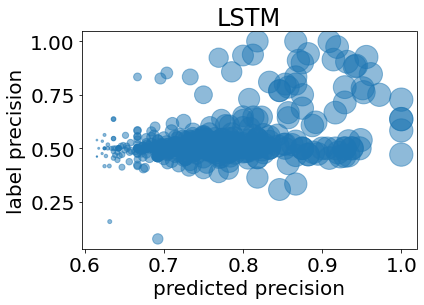

In [48]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.5)
plt.xlabel('predicted precision')
plt.ylabel('label precision')
plt.title('LSTM')
plt.savefig("results/spam.png")

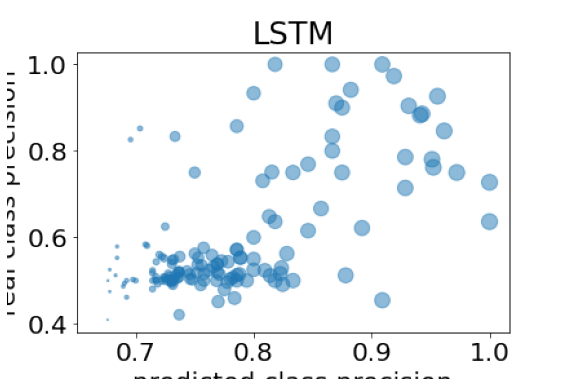

In [31]:
img = plt.imread("results/gru_on_counter.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)